# Upstart Data Challenge
Yuyao Hu 
11/01/2018

### Q: What fraction of these loans will have charged off by the time of all their 3-year terms are finished


## Assumptions:

1)  For those loans without the number of days from origination to chargeoff, 
    it dose mean that it haven't chargeed off by the day the data was collected. 
    There is no guarentee that those loans will not charge off in the future.

2)  3 years = 3 * 365 = 1095 days

3)  We predict the number of charged off loans only based on the number of days since a loan originates.  
Which means that the amount of each loan are considerd to be all the same, and at the same time all personal information and conditions like income level, Fico Score are all ignored in this case.

## 0. Dataset Exploration

### 0.1 Read in the dataset

In [25]:
import os
import pandas as pd
import numpy as np 
# print(pd.__version__)

path = "./data/"
filename_read = os.path.join(path, 'loan_timing.csv')
filename_write = os.path.join(path, 'output.csv')
# print(filename_read)
# print(filename_write)

df = pd.read_csv(filename_read)
# df = df.astype(int)
df[15:20]

,days since origination,days from origination to chargeoff
15,400,390.0
16,721,362.0
17,562,NaN
18,101,NaN
19,52,NaN


In [26]:
# find those records of loans have been charged off
df2 = df[df['days from origination to chargeoff'] <= 730]
df2[0:5]

,days since origination,days from origination to chargeoff
14,327,78.0
15,400,390.0
16,721,362.0
26,410,48.0
61,649,412.0


In [27]:
print('There are total ' + str(len(df)) + ' loans. ' + str(len(df2)) + ' of them have been charged off by the day the data was collected.')

There are total 50000 loans. 3305 of them have been charged off by the day the data was collected.


### 0.2 Find min/max value for days

In [28]:
oriMin = np.nanmin(df['days since origination'])
oriMax = np.nanmax(df['days since origination'])
oriAvg = np.nanmean(df['days since origination'])
chaMin = np.nanmin(df['days from origination to chargeoff'])
chaMax = np.nanmax(df['days from origination to chargeoff'])
print(oriMin, oriMax, oriAvg, chaMin, chaMax)

0 730 365.84476 0.0 725.0


### 0.3 Draw histogram to have a basic impression of the distribution

#### 0.3.1 All loans
    
__The choise of the best number of bins__

    1) Sturges' rule
    
        works well for n <= 200, 
        
        in this case we have len(df['days since origination']) = 50000 
    
    2) Freedman–Diaconis rule

In [29]:
# Freedman–Diaconis rule
from IPython.display import display, Math, Latex
display(Math(r'binSize = 2\frac{IQR(x)}{\sqrt[3]{N}}'))

<IPython.core.display.Math object>

In [30]:
from scipy.stats import iqr
import math

binsize = math.ceil(2 * iqr(df['days since origination']) / np.power(len(df['days since origination']), 1/3))
print(binsize)
bins = [i for i in range(0, 730 + binsize, binsize)]
# print(bins)

20


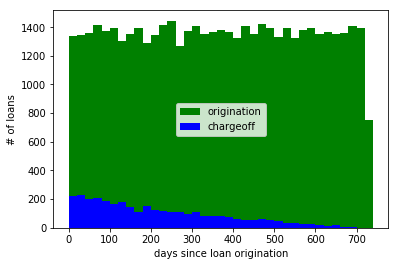

In [31]:
from matplotlib import pyplot as plt 

ori = plt.hist(df['days since origination'], bins, color='g', label='origination') 

# fillin NaNs with 10000, otherwise we are not able to draw a histogram of the charde off data
df1 = df['days from origination to chargeoff'].fillna(10000).astype(int)
chargeoff = plt.hist(df1, bins, color='b', label='chargeoff') 

plt.legend(loc = 'center')
plt.xlabel('days since loan origination')
plt.ylabel('# of loans')
plt.show()

As what we can see from the hist, the number of loans is relatively even distributed by the initiation dates.

It shows that for each twenty days(binsize = 20), the number of loan origination is relatively stable at ~1350, with a standard variance at about ~106.

In [32]:
numOris, Days = np.histogram(df['days since origination'], bins) 
avgNumOris = np.mean(numOris)
stdNumOris = np.std(numOris)
print(avgNumOris, stdNumOris)

1351.3513513513512 106.28269702714096


Actually if we change the binsize down to 10, then we'll can achieve a better variance.

For each 10 days, there are ~685 new loan be originated, with a standard variance at about 28.7

684.931506849315 28.679776067181066


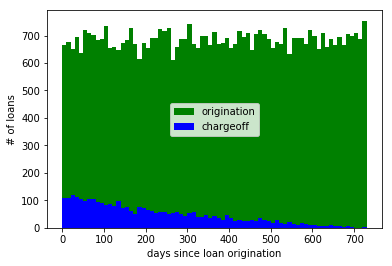

In [33]:
binsize = 10
bins = [i for i in range(0, 730 + binsize, binsize)]
numOris, Days = np.histogram(df['days since origination'], bins) 
avgNumOris = np.mean(numOris)
stdNumOris = np.std(numOris)
print(avgNumOris, stdNumOris)

ori = plt.hist(df['days since origination'], bins, color='g', label='origination') 
chargeoff = plt.hist(df1, bins, color='b', label='chargeoff') 

plt.legend(loc = 'center')
plt.xlabel('days since loan origination')
plt.ylabel('# of loans')
plt.show()

For the chargeoff data, it shows that most of the borrower stops making payments in a very early stage.

In this total 3305 charged-off loans, most of them(80%) occur within the first year(~360 days).

In [34]:
numChas, chDays = np.histogram(df1, bins) 
# print(numChas, chDays)

sum = 0
for i in range(len(numChas)):
    sum += numChas[i]
    if sum >= 3305 * 0.8:
        print(chDays[i])
        break

360


#### 0.3.2 Loans that have been charged off

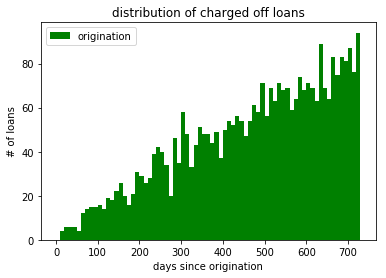

In [35]:
#binsize2 = math.ceil(2 * iqr(df2['days since origination']) / np.power(len(df2['days since origination']), 1/3))
#print(binsize2)
#bins = [i for i in range(0, 730 + 5, 5)]

ori = plt.hist(df2['days since origination'], bins, color='g', label='origination') 
# chargeoff = plt.hist(df2['days from origination to chargeoff'], bins2, color='b', label='chargeoff') 

plt.legend(loc = 'upper left')

plt.title('distribution of charged off loans')
plt.xlabel('days since origination')
plt.ylabel('# of loans')
plt.show()

The hist above shows the distribution of the start days of those loans have reported as charged off.

It is not surprising that for those "older" loans, they have higher probablity to be charged off.

(There is one thing we need to notice here, for those loans haven't charged off, it doesn't mean that they will not be charged off later.)

So we can probably fit a line/curve using this number - days data, and use this to predict what will happen by the end of these three years. In this case, this could be tranform to a __regression problem__.

In this regression problem, we will try find a model to predict *ŷ* given *x*.

Where *ŷ* is the number of charged off loans while *x* is the number of days since loan origination.

After we have the model, we can have *ŷ*s for *x* in the range(730, 1095) which indicate the third year.

We can sum up the *y*s for *x* ∈ (365, 1095) to get the total number of charged off loans.
Then the fraction of charged off loans in these 50000 loans will be easy to answer.


## 1. Prediction based on # of charged-off loans - initiation days

First build up the data we will work with:

In [36]:
numCharged, days = np.histogram(df2['days since origination'], bins)
# print(numCharged, days)

chargedNum = np.array([numCharged]).T
oriDays = np.array([days]).T

d = {'oriDays': days[0:len(days)-1], 'chargedNum': numCharged}

data = pd.DataFrame(d)
data[0:5]

,oriDays,chargedNum
0,0,0
1,10,4
2,20,6
3,30,6
4,40,6


### 1.0 Data Preparation

Here we need to split our data into training - test/validation sets.

We can do this in two kind of ways.

    1) Split data into 2 parts by the number of days loans initiated.
        The advantage of the first choise is that we are trying to work with prediction in the future, at this point, this split will provide us with more accurate estimate of our model.
    
    2) Split data into 2 parts at random.
        By split data randomly, we are able to apply cross-validation. Cross-validation utilize all our data into the training process and the validation error is known as a good stimulation of the test error.
    
I will try models on both these two split, with a fraction of 80%-20%.

#### 1.0.1 Split by dates

In [37]:
# 0.8-0.2
trainNum = math.ceil(len(data) * 0.8)
train = data[0: trainNum]
test = data[trainNum: len(data)]
# print(len(train), len(test), len(data))
train[0:5]

,oriDays,chargedNum
0,0,0
1,10,4
2,20,6
3,30,6
4,40,6


#### 1.0.2 Random Split

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['oriDays'], data['chargedNum'], test_size=0.2)

### 1.1 Prediction - Linear regression

The most simple idea is to use the linear model provied in sklearn.

#### 1.1.1 lin reg on split1

[0.11637054] 4.099999999999994
0.9328408897715633


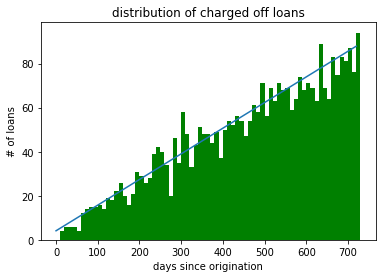

In [39]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train['oriDays'].values.reshape(-1, 1), train['chargedNum'])
print(model.coef_, model.intercept_)

rSquare = model.score(data['oriDays'].values.reshape(-1, 1), data['chargedNum'])
print(rSquare)
# days = [i for i in range(0, 1095 + binsize, binsize)]
yHat1 = data['oriDays'] * model.coef_ + model.intercept_

ori = plt.hist(df2['days since origination'], bins, color='g', label='origination') 
reg1 = plt.plot(data['oriDays'], yHat1)

plt.title('distribution of charged off loans')
plt.xlabel('days since origination')
plt.ylabel('# of loans')
plt.show()

#### 1.1.2 lin-reg on split2

[0.11314409] 4.1639704981833745
0.9348818187492981


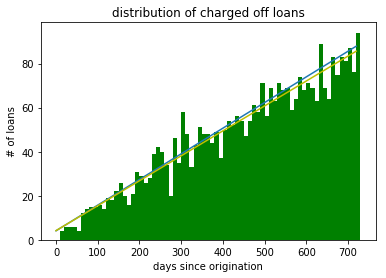

In [40]:
model.fit(X_train.values.reshape(-1, 1), y_train)
print(model.coef_, model.intercept_)

rSquare = model.score(data['oriDays'].values.reshape(-1, 1), data['chargedNum'])
print(rSquare)
yHat2 = data['oriDays'] * model.coef_ + model.intercept_

ori = plt.hist(df2['days since origination'], bins, color='g', label='origination') 
reg1 = plt.plot(data['oriDays'], yHat1)
reg2 = plt.plot(data['oriDays'], yHat2, 'y')

plt.title('distribution of charged off loans')
plt.xlabel('days since origination')
plt.ylabel('# of loans')
plt.show()

##### The new yellow line in the figure is the prediction line based on random split.

To eliminate the influence of the choise of binsize.
I tried another time with split1 and binsize = 5 and 1:

68.4931506849315 8.922379570298057
[0.00923437] 0.17288135593220338
0.4291708783234275


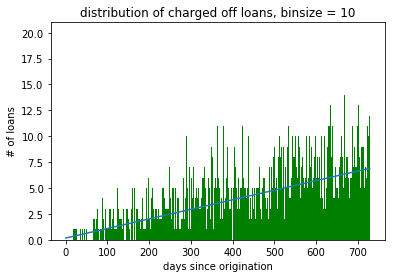

In [41]:
binsize1 = 1
bins1 = [i for i in range(0, 730 + binsize1, binsize1)]
numOris1, Days1 = np.histogram(df['days since origination'], bins1) 
avgNumOris1 = np.mean(numOris1)
stdNumOris1 = np.std(numOris1)
print(avgNumOris1, stdNumOris1)

numCharged, days = np.histogram(df2['days since origination'], bins1)
# print(numCharged, days)

chargedNum1 = np.array([numCharged]).T
oriDays1 = np.array([days]).T

d1 = {'oriDays': days[0:len(days)-1], 'chargedNum': numCharged}

data1 = pd.DataFrame(d1)
trainNum1 = math.ceil(len(data) * 0.8)
train1 = data1[0: trainNum1]
test1 = data1[trainNum1: len(data)]

model1 = LinearRegression()
model1.fit(train1['oriDays'].values.reshape(-1, 1), train1['chargedNum'])
print(model1.coef_, model1.intercept_)

rSquare1 = model1.score(data1['oriDays'].values.reshape(-1, 1), data1['chargedNum'])
print(rSquare1)
yHat11 = data1['oriDays'] * model1.coef_ + model1.intercept_

ori1 = plt.hist(df2['days since origination'], bins1, color='g', label='origination') 
reg11 = plt.plot(data1['oriDays'], yHat11)

plt.title('distribution of charged off loans, binsize = 10')
plt.xlabel('days since origination')
plt.ylabel('# of loans')
plt.show()

The result shows that with binsize = 10, we have a better coefficient of determination at ~ 0.93.
So I will work on the whole dataset with binsize = 10 to train the model and make the prediction.

[0.11183512] 5.013328396890039
0.9352507490661497


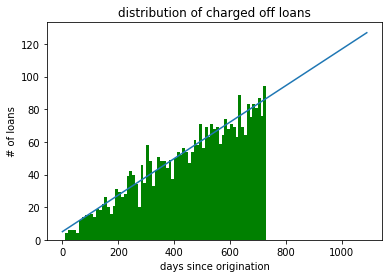

In [214]:
model = LinearRegression()
model.fit(data['oriDays'].values.reshape(-1, 1), data['chargedNum'])
print(model.coef_, model.intercept_)

rSquare = model.score(data['oriDays'].values.reshape(-1, 1), data['chargedNum'])
print(rSquare)
days = [i for i in range(0, 1095, binsize)]
yHat = days * model.coef_ + model.intercept_

ori = plt.hist(df2['days since origination'], bins, color='g', label='origination') 
reg = plt.plot(days, yHat)

plt.title('distribution of charged off loans')
plt.xlabel('days since origination')
plt.ylabel('# of loans')
plt.show()

To compute how many loans will charge off by the end of the 1095 days, we can simply use (yHat|x = 1095) / average number of loan originations in each binsize days.

In [215]:
yPred = 1095 * model.coef_ + model.intercept_
numChargedOff3years = yPred * 1095 / binsize
print(numChargedOff3years, numChargedOff3years / len(df))

[13958.27027027] [0.27916541]


The result here shows that ~13958 loans will be charged off.

With the fraction of **~27.9%** of the total 50000 loans.

### 1.2 Prediction - Regression Tree

Compare to linear regression, regression tree model will provide us more flexibility when describing the data.

#### 1.2.1 Tree Regression based on Split1

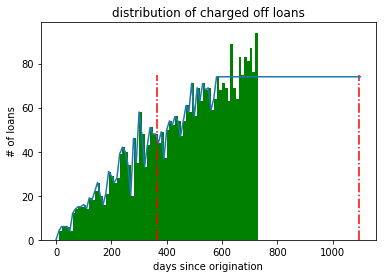

In [44]:
from sklearn import tree
model = tree.DecisionTreeRegressor()
model.fit(train['oriDays'].values.reshape(-1, 1), train['chargedNum'])

days = [i for i in range(0, 1095 + binsize, binsize)]
yHat1 = model.predict(np.array(days).reshape(-1, 1))

ori = plt.hist(df2['days since origination'], bins, color='g', label='origination') 
reg1 = plt.plot(days, yHat1)

plt.title('distribution of charged off loans')
plt.xlabel('days since origination')
plt.ylabel('# of loans')
plt.vlines(365, 0, max(yHat1) + 1, colors = 'r', linestyles='dashdot')
plt.vlines(1095, 0, max(yHat1) + 1, colors = 'r', linestyles='dashdot')
plt.show()

#### 1.2.2 Split2

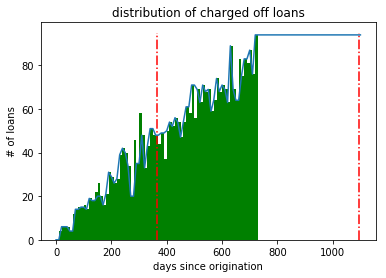

In [45]:
model = tree.DecisionTreeRegressor()
model.fit(X_train.values.reshape(-1, 1), y_train)

days = [i for i in range(0, 1095 + binsize, binsize)]
yHat1 = model.predict(np.array(days).reshape(-1, 1))

ori = plt.hist(df2['days since origination'], bins, color='g', label='origination') 
reg1 = plt.plot(days, yHat1)

plt.title('distribution of charged off loans')
plt.xlabel('days since origination')
plt.ylabel('# of loans')
plt.vlines(365, 0, max(yHat1) + 1, colors = 'r', linestyles='dashdot')
plt.vlines(1095, 0, max(yHat1) + 1, colors = 'r', linestyles='dashdot')
plt.show()

It is not surprising that regression trees are not able to predict numbers have not seen before.

### 1.3 LSTM(Long Short Term Memory Network)

A long-short term memory network is a RNN which has the ability to learnin from a long sequence of observations. It has been used for time series forecastings, such as stock price predictions. 

And in this case we shall use to split1 to choose the best model(parameters).

#### 1.3.1 Dataset Visualization

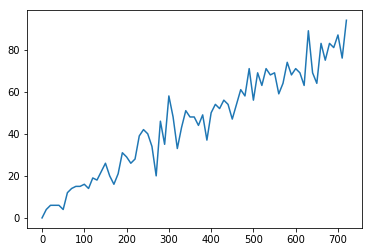

In [46]:
plt.plot(oriDays[0: len(oriDays) - 1], chargedNum)

#### 1.3.2 data preparation

In [87]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(chargedNum)
# dataset = chargedNum

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

C:\Users\may-y\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### 1.3.3 find best network parameters

For a basic LSTM model in keras, there are two important parameters: *number of lookback*, *size of the hidden layer*

Here we will try a lookback in the range[1, 4, 8, 12] and size of the hidden layer [4, 8, 16]

In [205]:
lookback = [1, 4, 8, 12]
hiddenSize = [4, 8, 16]
result = []

for look_back in lookback:
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    
    for hSize in hiddenSize:
        model = Sequential([LSTM(hSize, input_shape=(1, look_back)), Dense(1)])
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
        
        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainYI = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testYI = scaler.inverse_transform([testY])
        
        trainScore = math.sqrt(mean_squared_error(trainYI[0], trainPredict[:,0]))
        testScore = math.sqrt(mean_squared_error(testYI[0], testPredict[:,0]))
        result.append([look_back, hSize, trainScore, testScore])
    
print (result)
        

Epoch 1/100
 - 4s - loss: 0.1725
Epoch 2/100
 - 1s - loss: 0.1112
Epoch 3/100
 - 1s - loss: 0.0706
Epoch 4/100
 - 1s - loss: 0.0456
Epoch 5/100
 - 1s - loss: 0.0329
Epoch 6/100
 - 1s - loss: 0.0273
Epoch 7/100
 - 1s - loss: 0.0247
Epoch 8/100
 - 1s - loss: 0.0235
Epoch 9/100
 - 1s - loss: 0.0226
Epoch 10/100
 - 1s - loss: 0.0216
Epoch 11/100
 - 1s - loss: 0.0206
Epoch 12/100
 - 1s - loss: 0.0196
Epoch 13/100
 - 1s - loss: 0.0188
Epoch 14/100
 - 1s - loss: 0.0179
Epoch 15/100
 - 1s - loss: 0.0171
Epoch 16/100
 - 1s - loss: 0.0162
Epoch 17/100
 - 1s - loss: 0.0155
Epoch 18/100
 - 1s - loss: 0.0147
Epoch 19/100
 - 1s - loss: 0.0139
Epoch 20/100
 - 1s - loss: 0.0132
Epoch 21/100
 - 1s - loss: 0.0126
Epoch 22/100
 - 1s - loss: 0.0120
Epoch 23/100
 - 1s - loss: 0.0114
Epoch 24/100
 - 1s - loss: 0.0110
Epoch 25/100
 - 1s - loss: 0.0106
Epoch 26/100
 - 1s - loss: 0.0102
Epoch 27/100
 - 1s - loss: 0.0097
Epoch 28/100
 - 1s - loss: 0.0094
Epoch 29/100
 - 1s - loss: 0.0091
Epoch 30/100
 - 1s - lo

Epoch 43/100
 - 1s - loss: 0.0076
Epoch 44/100
 - 1s - loss: 0.0075
Epoch 45/100
 - 1s - loss: 0.0076
Epoch 46/100
 - 1s - loss: 0.0074
Epoch 47/100
 - 1s - loss: 0.0077
Epoch 48/100
 - 1s - loss: 0.0075
Epoch 49/100
 - 1s - loss: 0.0078
Epoch 50/100
 - 1s - loss: 0.0077
Epoch 51/100
 - 1s - loss: 0.0075
Epoch 52/100
 - 1s - loss: 0.0075
Epoch 53/100
 - 1s - loss: 0.0076
Epoch 54/100
 - 1s - loss: 0.0075
Epoch 55/100
 - 1s - loss: 0.0075
Epoch 56/100
 - 1s - loss: 0.0074
Epoch 57/100
 - 1s - loss: 0.0075
Epoch 58/100
 - 1s - loss: 0.0078
Epoch 59/100
 - 1s - loss: 0.0077
Epoch 60/100
 - 1s - loss: 0.0077
Epoch 61/100
 - 1s - loss: 0.0075
Epoch 62/100
 - 1s - loss: 0.0076
Epoch 63/100
 - 1s - loss: 0.0078
Epoch 64/100
 - 1s - loss: 0.0076
Epoch 65/100
 - 1s - loss: 0.0076
Epoch 66/100
 - 1s - loss: 0.0074
Epoch 67/100
 - 1s - loss: 0.0076
Epoch 68/100
 - 1s - loss: 0.0074
Epoch 69/100
 - 1s - loss: 0.0075
Epoch 70/100
 - 1s - loss: 0.0077
Epoch 71/100
 - 1s - loss: 0.0075
Epoch 72/100
 

Epoch 85/100
 - 1s - loss: 0.0059
Epoch 86/100
 - 1s - loss: 0.0058
Epoch 87/100
 - 1s - loss: 0.0057
Epoch 88/100
 - 1s - loss: 0.0056
Epoch 89/100
 - 1s - loss: 0.0057
Epoch 90/100
 - 1s - loss: 0.0056
Epoch 91/100
 - 1s - loss: 0.0056
Epoch 92/100
 - 1s - loss: 0.0056
Epoch 93/100
 - 1s - loss: 0.0056
Epoch 94/100
 - 1s - loss: 0.0056
Epoch 95/100
 - 1s - loss: 0.0056
Epoch 96/100
 - 1s - loss: 0.0055
Epoch 97/100
 - 1s - loss: 0.0055
Epoch 98/100
 - 1s - loss: 0.0055
Epoch 99/100
 - 1s - loss: 0.0056
Epoch 100/100
 - 1s - loss: 0.0055
Epoch 1/100
 - 5s - loss: 0.0979
Epoch 2/100
 - 1s - loss: 0.0196
Epoch 3/100
 - 1s - loss: 0.0085
Epoch 4/100
 - 1s - loss: 0.0080
Epoch 5/100
 - 1s - loss: 0.0074
Epoch 6/100
 - 1s - loss: 0.0070
Epoch 7/100
 - 1s - loss: 0.0066
Epoch 8/100
 - 1s - loss: 0.0065
Epoch 9/100
 - 1s - loss: 0.0066
Epoch 10/100
 - 1s - loss: 0.0065
Epoch 11/100
 - 1s - loss: 0.0061
Epoch 12/100
 - 1s - loss: 0.0061
Epoch 13/100
 - 1s - loss: 0.0060
Epoch 14/100
 - 1s - l

Epoch 27/100
 - 1s - loss: 0.0051
Epoch 28/100
 - 1s - loss: 0.0049
Epoch 29/100
 - 1s - loss: 0.0058
Epoch 30/100
 - 1s - loss: 0.0049
Epoch 31/100
 - 1s - loss: 0.0046
Epoch 32/100
 - 1s - loss: 0.0054
Epoch 33/100
 - 1s - loss: 0.0049
Epoch 34/100
 - 1s - loss: 0.0048
Epoch 35/100
 - 0s - loss: 0.0051
Epoch 36/100
 - 1s - loss: 0.0052
Epoch 37/100
 - 0s - loss: 0.0049
Epoch 38/100
 - 1s - loss: 0.0049
Epoch 39/100
 - 0s - loss: 0.0050
Epoch 40/100
 - 1s - loss: 0.0048
Epoch 41/100
 - 0s - loss: 0.0047
Epoch 42/100
 - 1s - loss: 0.0049
Epoch 43/100
 - 1s - loss: 0.0047
Epoch 44/100
 - 1s - loss: 0.0049
Epoch 45/100
 - 1s - loss: 0.0046
Epoch 46/100
 - 1s - loss: 0.0046
Epoch 47/100
 - 1s - loss: 0.0050
Epoch 48/100
 - 1s - loss: 0.0049
Epoch 49/100
 - 0s - loss: 0.0045
Epoch 50/100
 - 1s - loss: 0.0046
Epoch 51/100
 - 1s - loss: 0.0045
Epoch 52/100
 - 1s - loss: 0.0047
Epoch 53/100
 - 1s - loss: 0.0049
Epoch 54/100
 - 1s - loss: 0.0046
Epoch 55/100
 - 1s - loss: 0.0044
Epoch 56/100
 

Epoch 69/100
 - 0s - loss: 0.0047
Epoch 70/100
 - 0s - loss: 0.0047
Epoch 71/100
 - 1s - loss: 0.0046
Epoch 72/100
 - 0s - loss: 0.0047
Epoch 73/100
 - 0s - loss: 0.0046
Epoch 74/100
 - 0s - loss: 0.0049
Epoch 75/100
 - 0s - loss: 0.0047
Epoch 76/100
 - 0s - loss: 0.0047
Epoch 77/100
 - 0s - loss: 0.0049
Epoch 78/100
 - 0s - loss: 0.0045
Epoch 79/100
 - 1s - loss: 0.0045
Epoch 80/100
 - 0s - loss: 0.0046
Epoch 81/100
 - 0s - loss: 0.0046
Epoch 82/100
 - 1s - loss: 0.0048
Epoch 83/100
 - 0s - loss: 0.0045
Epoch 84/100
 - 0s - loss: 0.0046
Epoch 85/100
 - 0s - loss: 0.0047
Epoch 86/100
 - 0s - loss: 0.0047
Epoch 87/100
 - 0s - loss: 0.0046
Epoch 88/100
 - 1s - loss: 0.0050
Epoch 89/100
 - 1s - loss: 0.0047
Epoch 90/100
 - 0s - loss: 0.0046
Epoch 91/100
 - 0s - loss: 0.0045
Epoch 92/100
 - 0s - loss: 0.0045
Epoch 93/100
 - 0s - loss: 0.0046
Epoch 94/100
 - 0s - loss: 0.0045
Epoch 95/100
 - 0s - loss: 0.0045
Epoch 96/100
 - 0s - loss: 0.0047
Epoch 97/100
 - 0s - loss: 0.0050
Epoch 98/100
 

In [240]:
minTestScore = float('inf')
for r in result:
    if r[3] < minTestScore:
        minTestScore = r[3]
        bestLB = r[0]
        bestHS = r[1]
        
print(bestLB, bestHS, minTestScore)

8 16 9.228067176879582


Based on the result, when lookBack = 8, hiddenSize = 16, we gain the best prediction result on test set.

Then we can use the whole data set to train a model with the best parameters we found and try to make a prediction.

#### 1.3.4 train on the whole dataset

In [241]:
X, y = create_dataset(dataset, bestLB)
X = numpy.reshape(X, (X.shape[0], 1, X.shape[1]))

model = Sequential([LSTM(bestHS, input_shape=(1, bestLB)), Dense(1)])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 4s - loss: 0.1531
Epoch 2/100
 - 1s - loss: 0.0148
Epoch 3/100
 - 1s - loss: 0.0061
Epoch 4/100
 - 1s - loss: 0.0060
Epoch 5/100
 - 1s - loss: 0.0058
Epoch 6/100
 - 1s - loss: 0.0058
Epoch 7/100
 - 1s - loss: 0.0058
Epoch 8/100
 - 1s - loss: 0.0057
Epoch 9/100
 - 1s - loss: 0.0055
Epoch 10/100
 - 1s - loss: 0.0055
Epoch 11/100
 - 1s - loss: 0.0056
Epoch 12/100
 - 1s - loss: 0.0057
Epoch 13/100
 - 1s - loss: 0.0058
Epoch 14/100
 - 1s - loss: 0.0056
Epoch 15/100
 - 1s - loss: 0.0058
Epoch 16/100
 - 1s - loss: 0.0057
Epoch 17/100
 - 1s - loss: 0.0058
Epoch 18/100
 - 1s - loss: 0.0060
Epoch 19/100
 - 1s - loss: 0.0054
Epoch 20/100
 - 1s - loss: 0.0055
Epoch 21/100
 - 1s - loss: 0.0055
Epoch 22/100
 - 1s - loss: 0.0054
Epoch 23/100
 - 1s - loss: 0.0056
Epoch 24/100
 - 1s - loss: 0.0057
Epoch 25/100
 - 1s - loss: 0.0055
Epoch 26/100
 - 1s - loss: 0.0055
Epoch 27/100
 - 1s - loss: 0.0053
Epoch 28/100
 - 1s - loss: 0.0055
Epoch 29/100
 - 1s - loss: 0.0054
Epoch 30/100
 - 1s - lo

In [242]:
print(X.shape)

(65, 1, 8)


65


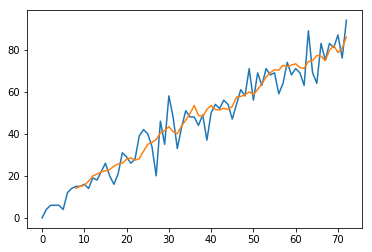

In [243]:
trainPredict = model.predict(X)
print(len(trainPredict))
# testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[bestLB : len(trainPredict)+bestLB, :] = scaler.inverse_transform(trainPredict)

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.show()

#### 1.3.5 Predict the future

Here we compute the prediction of the previous stage and use it to predicte its next stage.

(102, 1)


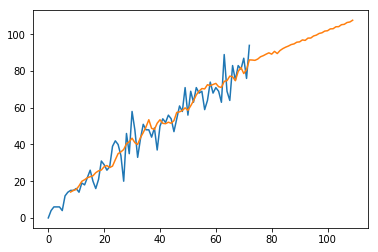

In [248]:
predData = X
currentStep = predData[-2: -1] #last step from the previous prediction

for i in range(730 // binsize, 1095 // binsize + 1):
    currentRes = model.predict(predData[-2: -1]) #get the next step
    nextPred = np.append(predData[-2: -1][0][0][1: bestLB], currentRes)
    nextPred = nextPred.reshape(1, 1, bestLB)
    predData = np.append(predData, nextPred).reshape(len(predData) +1, 1, bestLB)

#after processing a sequence, reset the states for safety
model.reset_states()
predFu = model.predict(predData)
print(predFu.shape)
# print(future)
plt.plot(scaler.inverse_transform(dataset))

predFuPlot = numpy.empty((len(predFu) + 2* bestLB, 1))
predFuPlot[:, :] = numpy.nan
predFuPlot[bestLB:len(predFu) + bestLB] = scaler.inverse_transform(predFu)
plt.plot(predFuPlot)
plt.show()

In [249]:
numChargedOff3years = predFuPlot[1095//binsize] * 1095 / binsize 
print(numChargedOff3years, numChargedOff3years / len(df))

[11792.14048004] [0.23584281]


It turns out that with a LSTM model, when all the loans reach their 1095 days, ~11792 of them will charged off, at a fraction at ~23.6%.

## 2. Conclusion

Both the basic linear regression model and the relatively complex LSTM model give the charged off rates at about ~25%.

For **Linear Regression**: ~27.9%

For **LSTM**: ~ 23.6%

The process of making this conclusion is actually very straightforward.

The dataset we have here is not very large and the information we can find in the dataset is relatively simple. As what I said before in the assumptions, with more information to consider, we may build up a better model for this prediction problem.

Due to the limited time, I was not able to run the LSTM for more times to choose a set of better parameters.

Also, I just ignore the information about "days from origination to chargeoff". At the first glance, it turns out that most of the loans are charged off within the first year. Which means that for those loans starts longer than 365 days, they are not likely to be charged off on the future. It seems conflict with the prediction I made before and I do expect to dive deeper in this aspect and have a logical explanation for both sides.